COVID

2019 Novel Coronavirus (2019-nCoV) is a virus (more specifically, a coronavirus) identified as the cause of an outbreak of respiratory illness first detected in Wuhan, China. Early on, many of the patients in the outbreak in Wuhan, China reportedly had some link to a large seafood and animal market, suggesting animal-to-person spread. However, a growing number of patients reportedly have not had exposure to animal markets, indicating person-to-person spread is occurring. At this time, it’s unclear how easily or sustainably this virus is spreading between people - CDC

This dataset has daily level information on the number of affected cases, deaths and recovery from 2019 novel coronavirus. Please note that this is a time series data and so the number of cases on any given day is the cumulative number.

The data is available from 22 Jan, 2020.

# EDA

In [47]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

In [2]:
# Import the dataset from Kaggle, located here: https://www.kaggle.com/abhinand05/covid-19-digging-a-bit-deeper

df = pd.read_csv('covid_19_data.csv')
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
df["ObservationDate"]=pd.to_datetime(df["ObservationDate"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8509 entries, 0 to 8508
Data columns (total 8 columns):
SNo                8509 non-null int64
ObservationDate    8509 non-null datetime64[ns]
Province/State     4761 non-null object
Country/Region     8509 non-null object
Last Update        8509 non-null object
Confirmed          8509 non-null float64
Deaths             8509 non-null float64
Recovered          8509 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 531.9+ KB


In [4]:
df.drop(columns = ['Province/State', 'Last Update', 'SNo'],inplace=True)

In [5]:
df["Country/Region"].replace({"Iran (Islamic Republic of)": "Iran", "Viet Nam":"Vietnam", "Taipei and environs": "Taiwan"}, inplace=True)

Index(['ObservationDate', 'Country/Region', 'Last Update', 'Confirmed',
       'Deaths', 'Recovered'],
      dtype='object')

## Data Engineering

In [6]:
bydate=df.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
# df.set_index(['ObservationDate'], inplace=True)
bydate.head()

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-22,555.0,28.0,17.0
2020-01-23,653.0,30.0,18.0
2020-01-24,941.0,36.0,26.0
2020-01-25,1438.0,39.0,42.0
2020-01-26,2118.0,52.0,56.0


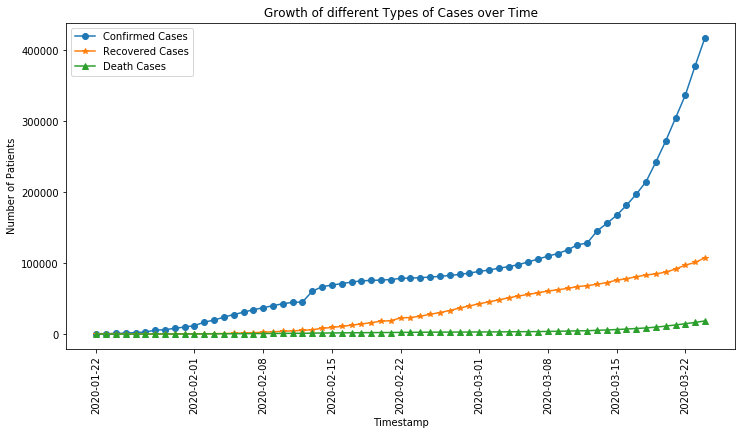

In [31]:
plt.figure(figsize=(12,6))
plt.plot(bydate["Confirmed"],marker="o",label="Confirmed Cases")
plt.plot(bydate["Recovered"],marker="*",label="Recovered Cases")
plt.plot(bydate["Deaths"],marker="^",label="Death Cases")
plt.ylabel("Number of Patients")
plt.xlabel("Timestamp")
plt.xticks(rotation=90)
plt.title("Growth of different Types of Cases over Time")
plt.legend()

In [8]:
print("Summary")
print("Total number of countries with Disease Spread: ",len(df["Country/Region"].unique()))
print("Total number of Confirmed Cases: ",bydate["Confirmed"].iloc[-1])
print("Total number of Recovered Cases: ",bydate["Recovered"].iloc[-1])
print("Total number of Deaths Cases: ",bydate["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(bydate["Confirmed"].iloc[-1]-bydate["Recovered"].iloc[-1]))

Summary
Total number of countries with Disease Spread:  205
Total number of Confirmed Cases:  417966.0
Total number of Recovered Cases:  107705.0
Total number of Deaths Cases:  18615.0
Total number of Active Cases around the World:  310261.0


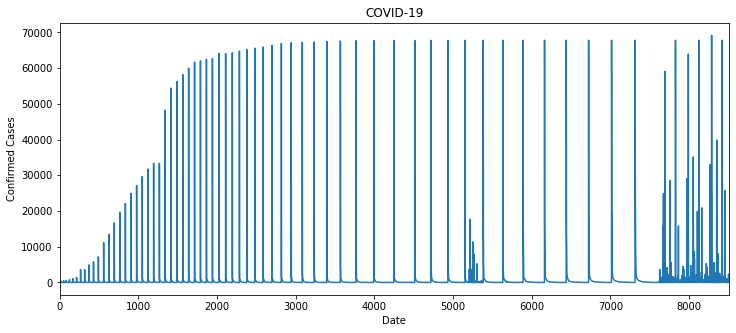

In [9]:
title='COVID-19'
ylabel='Confirmed Cases'
xlabel='Date'

ax = df['Confirmed'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [10]:
bydate

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-22,555.0,28.0,17.0
2020-01-23,653.0,30.0,18.0
2020-01-24,941.0,36.0,26.0
2020-01-25,1438.0,39.0,42.0
2020-01-26,2118.0,52.0,56.0
...,...,...,...
2020-03-20,272167.0,87403.0,11299.0
2020-03-21,304528.0,91676.0,12973.0
2020-03-22,337020.0,97243.0,14623.0


In [13]:
# x= df["ObservationDate"]
# y=[df.Confirmed.values, df.Deaths.values, df.Recovered.values]
 
# # Plot
# pal = sns.color_palette("Set1")
# plt.figure(figsize=[12.0, 7.0])
# plt.stackplot(x,y, labels=['Confirmed','Deaths','Recovered'], colors=pal, alpha=0.7)
# plt.legend(loc='upper left')
# plt.show()

<Figure size 432x288 with 0 Axes>

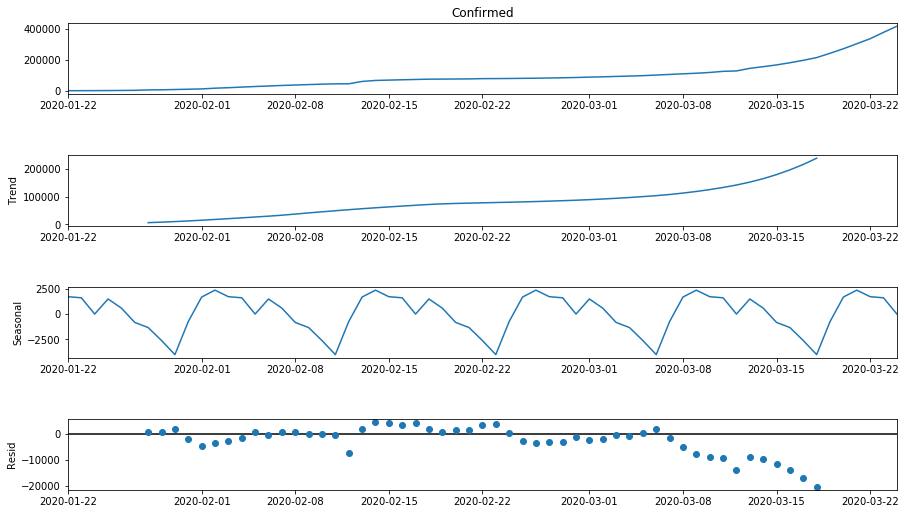

In [32]:
decomposition = seasonal_decompose(bydate['Confirmed'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [40]:
bydate['natural_log'] = bydate.Confirmed.apply(lambda x: np.log(x))

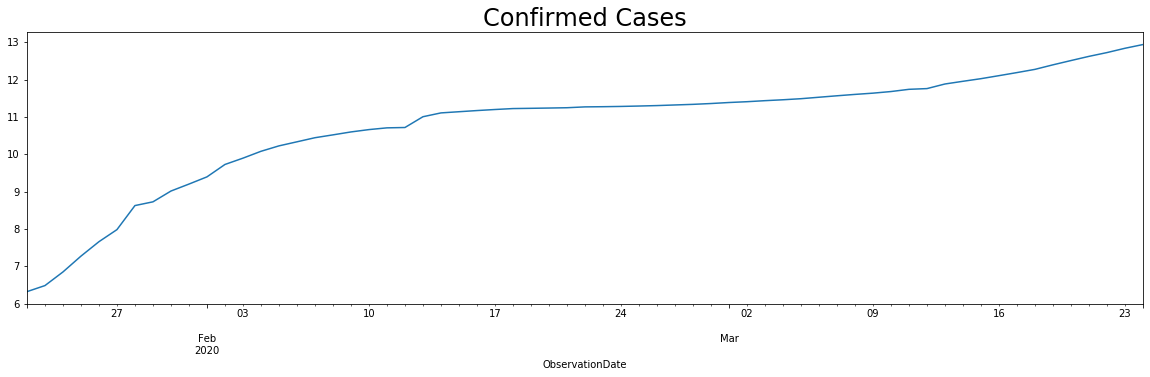

In [42]:
bydate.natural_log.plot(figsize = (20,5))
plt.title("Confirmed Cases", size= 24)
plt.show()

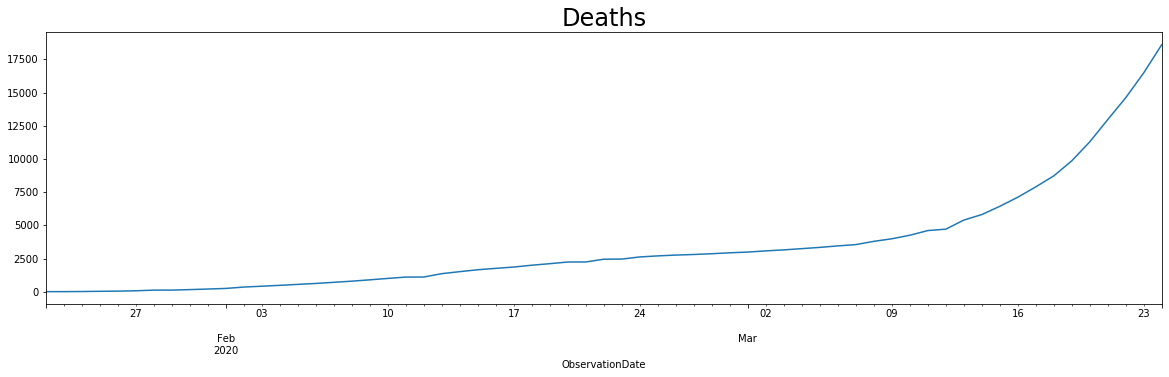

In [17]:
bydate.Deaths.plot(figsize = (20,5))
plt.title("Deaths", size= 24)
plt.show()

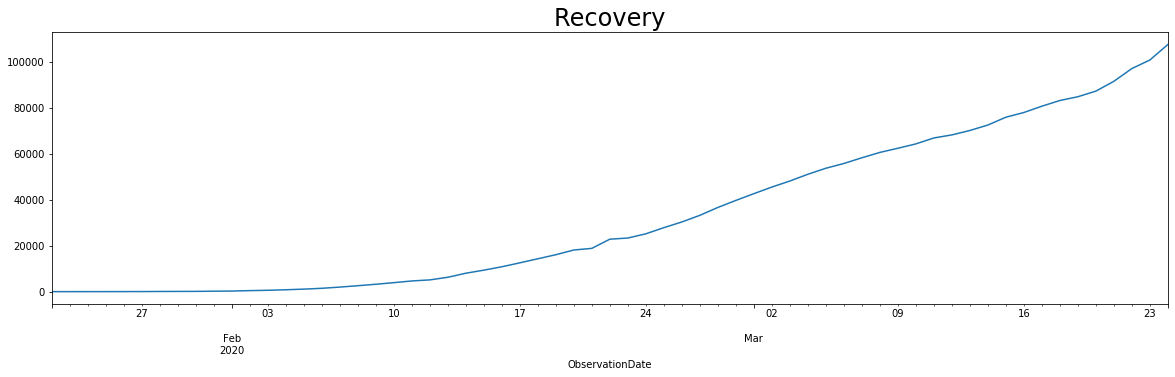

In [18]:
bydate.Recovered.plot(figsize = (20,5))
plt.title("Recovery", size= 24)
plt.show()

# Splitting the Data

# Models

## Dickey-Fuller Tests

In [43]:
sts.adfuller(df_train.Confirmed) # dickey-fuller test to check for staionarity 

(0.5121314298729323,
 0.9852371943124696,
 1,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 706.3376933328723)

In [44]:
sts.adfuller(bydate.natural_log) # dickey-fuller test to check for staionarity 

(-1.4938591111880821,
 0.5365469319938787,
 3,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 -168.215861662929)

In [21]:
sts.adfuller(bydate.Deaths)

(2.773343055655312,
 1.0,
 11,
 51,
 {'1%': -3.5656240522121956,
  '5%': -2.920142229157715,
  '10%': -2.598014675124952},
 618.3059353125927)

In [22]:
sts.adfuller(bydate.Recovered)

(1.559347271808673,
 0.9977303411854033,
 3,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 835.8953065011945)

## AR Model

In [23]:
model_ar = ARMA(bydate.Confirmed, order=(1,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                   63
Model:                     ARMA(1, 0)   Log Likelihood                -684.053
Method:                       css-mle   S.D. of innovations          11994.256
Date:                Thu, 26 Mar 2020   AIC                           1374.106
Time:                        11:16:32   BIC                           1380.535
Sample:                    01-22-2020   HQIC                          1376.635
                         - 03-24-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9.514e+04   3.08e+05      0.309      0.757   -5.09e+05    6.99e+05
ar.L1.Confirmed     0.9986      0.003    378.407      0.000       0.993       1.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0014           +0.0000j            1.0014            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
model_ar_2 = ARMA(df_train.Confirmed, order=(2,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                   50
Model:                     ARMA(2, 0)   Log Likelihood                -466.051
Method:                       css-mle   S.D. of innovations           2516.148
Date:                Thu, 26 Mar 2020   AIC                            940.103
Time:                        11:16:33   BIC                            947.751
Sample:                    01-22-2020   HQIC                           943.015
                         - 03-11-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.701e+04   5.97e+04      0.955      0.339   -5.99e+04    1.74e+05
ar.L1.Confirmed     1.7093      0.101     16.861      0.000       1.511       1.908
ar.L2.Confirmed    -0.7121      0.102     -6.972      0.000      -0.912      -0.512
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0098           +0.0000j            1.0098            0.0000
AR.2            1.3907           +0.0000j            1.3907            0.0000
-----------------------------------------------------------------------------
"""

In [25]:
model_ar_3 = ARMA(df_train.Confirmed, order=(3,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                   50
Model:                     ARMA(3, 0)   Log Likelihood                -464.573
Method:                       css-mle   S.D. of innovations           2436.571
Date:                Thu, 26 Mar 2020   AIC                            939.145
Time:                        11:16:33   BIC                            948.705
Sample:                    01-22-2020   HQIC                           942.786
                         - 03-11-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.701e+04   5.99e+04      0.952      0.341   -6.04e+04    1.74e+05
ar.L1.Confirmed     1.5388      0.137     11.244      0.000       1.271       1.807
ar.L2.Confirmed    -0.2954      0.257     -1.150      0.250      -0.799       0.208
ar.L3.Confirmed    -0.2468      0.140     -1.758      0.079      -0.522       0.028
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0176           +0.0000j            1.0176            0.0000
AR.2            1.1748           +0.0000j            1.1748            0.0000
AR.3           -3.3892           +0.0000j            3.3892            0.5000
-----------------------------------------------------------------------------
"""

In [26]:
model_ar_4 = ARMA(df_train.Confirmed, order=(4,0))
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Confirmed   No. Observations:                   50
Model:                     ARMA(4, 0)   Log Likelihood                -462.819
Method:                       css-mle   S.D. of innovations           2344.142
Date:                Thu, 26 Mar 2020   AIC                            937.638
Time:                        11:16:33   BIC                            949.110
Sample:                    01-22-2020   HQIC                           942.007
                         - 03-11-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.701e+04    6.1e+04      0.934      0.350   -6.26e+04    1.77e+05
ar.L1.Confirmed     1.4690      0.137     10.713      0.000       1.200       1.738
ar.L2.Confirmed    -0.3618      0.252     -1.436      0.151      -0.856       0.132
ar.L3.Confirmed     0.1539      0.250      0.616      0.538      -0.335       0.643
ar.L4.Confirmed    -0.2651      0.139     -1.912      0.056      -0.537       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0472           -0.0189j            1.0473           -0.0029
AR.2            1.0472           +0.0189j            1.0473            0.0029
AR.3           -0.7570           -1.6928j            1.8543           -0.3169
AR.4           -0.7570           +1.6928j            1.8543            0.3169
-----------------------------------------------------------------------------
"""

## ARIMA

In [52]:
sm.tsa.statespace.SARIMAX()

NameError: name 'endog' is not defined

In [ ]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(5, 1, 4),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())